In [1]:
import pandas as pd
import json, os, sys
import logging
from datetime import datetime
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
#from localutils.metricshelper import extract_cwe_for_cve
from functools import lru_cache as LRU

# set up the current date and time as one string
current_date = datetime.now().strftime('%Y-%m-%d')
current_time = datetime.now().strftime('%H:%M:%S')


#Set up logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(f"logs/app-{current_date+current_time}.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [2]:
# show all lines for dataframe
pd.set_option('display.max_rows', None)
# show original length of columns for dataframe
pd.set_option('display.max_columns', None)

In [ ]:
cve_data = pd.read_csv('output/cves_epss_kev_enriched-2025-02-25.csv')

/var/folders/7z/yz2432ws1sn3rvp0tf40s2d00000gp/T/ipykernel_66741/3760362291.py:1: DtypeWarning: Columns (21,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  cve_data = pd.read_csv('output/cves_epss_kev_enriched-2025-02-25.csv')


Text(0.5, 1.0, 'Top 10 CWEs for CVEs 2015-2025')

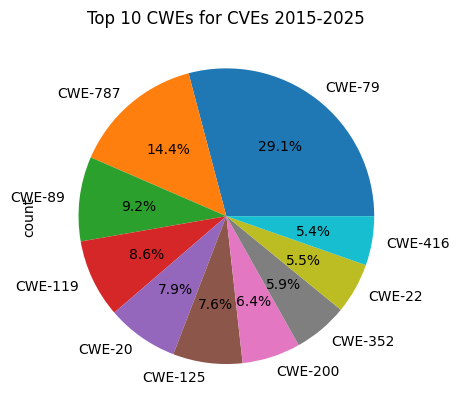

In [4]:
# plot top 10 CWEs without 'not_found' and 'NVD-CWE-noinfo' values
cve_data['cwe_id'].value_counts().drop(['NVD-CWE-noinfo', 'NVD-CWE-Other']).head(10).plot(kind='pie', autopct='%1.1f%%')
plt.title('Top 10 CWEs for CVEs 2015-2025')

In [5]:
# top 10 CWEs without 'not_found' and 'NVD-CWE-noinfo' values for years 2020-2025
cve_data[cve_data['cve_id'].str.contains('202[0-5]')]['cwe_id'].value_counts().drop(['NVD-CWE-noinfo', 'NVD-CWE-Other']).head(10).plot(kind='pie', autopct='%1.1f%%')
plt.title('Top 10 CWEs for CVEs 2020-2025')


ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [6]:
list_of_cwes = list(set(cve_data[~cve_data['cwe_id'].isin(['not_found', 'NVD-CWE-noinfo', 'NVD-CWE-Other'])]["cwe_id"].to_list()))


In [36]:
import requests
url = f"https://cwe-api.mitre.org/api/v1/cwe/weakness/1"
response = requests.get(url)
cwe_data = response.json()

In [37]:
cwe_data

'for weakness: cwe (1) not found, use the category endpoint'

In [15]:
def list_to_csv(lst: list) -> str:
    """Converts a list of strings to a comma-separated string."""
    return ", ".join(str(item).strip() for item in lst if item is not None)

In [ ]:
list_to_csv(cwe_data["Weaknesses"][0]["CommonConsequences"][0]["Scope"])

'Confidentiality, Integrity, Availability'

In [17]:
list_to_csv(cwe_data["Weaknesses"][0]["CommonConsequences"][0]["Impact"])

'Read Application Data, Execute Unauthorized Code or Commands'

In [ ]:
import requests

# add cwe descriptions to cwe_id in cves_cwes_df by matching CWE-ID with the cwes dataframe
@LRU(maxsize=128)
def get_cwe_name_and_description(cwe_id):
	try:
		logger.info(f"Getting CWE data for {cwe_id}")
		url = f"https://cwe-api.mitre.org/api/v1/cwe/weakness/{cwe_id.split('-')[1]}"
		response = requests.get(url)
		cwe_data = response.json()
		if cwe_data == f"for weakness: cwe ({cwe_id.split('-')[1]}) not found, use the category endpoint":
			return {"cwe_id": cwe_id, "cwe_name": "not_found", "cwe_desc": "not_found", "cwe_cc_scope": "not_found", "cwe_cc_impact": "not_found"}
		cwe_name =  cwe_data.get("Weaknesses")[0].get("Name") if cwe_data.get("Weaknesses")[0].get("Name") else "not_found"
		cwe_description = cwe_data.get("Weaknesses")[0].get("Description") if cwe_data.get("Weaknesses")[0].get("Description") else "not_found"
		cwe_cc_impact = list_to_csv(cwe_data.get("Weaknesses")[0].get("CommonConsequences")[0].get("Impact")) if cwe_data.get("Weaknesses")[0].get("CommonConsequences") else "not_found"
		cwe_cc_scope = list_to_csv(cwe_data.get("Weaknesses")[0].get("CommonConsequences")[0].get("Scope")) if cwe_data.get("Weaknesses")[0].get("CommonConsequences") else "not_found"
		return {"cwe_id": cwe_id, "cwe_name": cwe_name, "cwe_desc": cwe_description, "cwe_cc_scope": cwe_cc_scope, "cwe_cc_impact": cwe_cc_impact}
	except Exception as e:
		logger.error(f"Error getting CWE data for {cwe_id}, error: {e}")
		return {"cwe_id": cwe_id, "cwe_name": "not_found", "cwe_desc": "not_found", "cwe_cc_scope": "not_found", "cwe_cc_impact": "not_found"}




cwes_df = pd.DataFrame([get_cwe_name_and_description(cwe_id) for cwe_id in list_of_cwes])

2025-02-27 21:34:25,150 - INFO - Getting CWE data for CWE-566
2025-02-27 21:34:25,650 - INFO - Getting CWE data for CWE-521
2025-02-27 21:34:26,104 - INFO - Getting CWE data for CWE-648
2025-02-27 21:34:26,569 - INFO - Getting CWE data for CWE-282
2025-02-27 21:34:27,010 - INFO - Getting CWE data for CWE-434
2025-02-27 21:34:27,620 - INFO - Getting CWE data for CWE-527
2025-02-27 21:34:28,061 - INFO - Getting CWE data for CWE-502
2025-02-27 21:34:28,627 - INFO - Getting CWE data for CWE-552
2025-02-27 21:34:29,098 - INFO - Getting CWE data for CWE-347
2025-02-27 21:34:29,543 - INFO - Getting CWE data for CWE-404
2025-02-27 21:34:30,178 - INFO - Getting CWE data for CWE-250
2025-02-27 21:34:30,737 - INFO - Getting CWE data for CWE-540
2025-02-27 21:34:31,207 - INFO - Getting CWE data for CWE-769
2025-02-27 21:34:31,686 - INFO - Getting CWE data for CWE-807
2025-02-27 21:34:32,304 - INFO - Getting CWE data for CWE-943
2025-02-27 21:34:32,857 - INFO - Getting CWE data for CWE-614
2025-02-

In [19]:
cve_data = cve_data.merge(cwes_df, on='cwe_id', how='left')

In [20]:
cve_data = cve_data.fillna("not_found")

In [21]:
cve_data.columns

Index(['cve_id', 'description', 'published_date', 'last_modified_date',
       'cvss_version', 'cwe_id', 'cvss_vector', 'attack_vector',
       'attack_complexity', 'privileges_required', 'user_interaction',
       'base_score', 'base_severity', 'exploitability_score', 'impact_score',
       'scope', 'confidentiality_impact', 'integrity_impact',
       'availability_impact', 'epss', 'percentile', 'cveID', 'vendorProject',
       'product', 'vulnerabilityName', 'dateAdded', 'shortDescription',
       'requiredAction', 'dueDate', 'knownRansomwareCampaignUse', 'notes',
       'cwes', 'Exploitation', 'Automatable', 'Technical Impact', 'cwe_name',
       'cwe_desc', 'cwe_cc_scope', 'cwe_cc_impact'],
      dtype='object')